In [1]:
%%time
spark

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


In [2]:
!pip install --upgrade colorama
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate(spark)

  Using cached colorama-0.3.9-py2.py3-none-any.whl
  Found existing installation: colorama 0.3.7
    Uninstalling colorama-0.3.7:
      Successfully uninstalled colorama-0.3.7
[WARNING] H2O requires colorama module of version 0.3.8 or newer. You have version 0.3.7.
You can upgrade to the newest version of the module running from the command line
    $ pip3 install --upgrade colorama
Connecting to H2O server at http://172.17.0.2:54321... successful.


H2O cluster uptime:,38 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,1 month and 12 days
H2O cluster name:,sparkling-water-jovyan_local-1512294653598
H2O cluster total nodes:,1
H2O cluster free memory:,2.379 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://172.17.0.2:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-jovyan_local-1512294653598
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://172.17.0.2:54321 (CMD + click in Mac OSX)

    


In [3]:
import pandas as pd
import numpy as np
import pandas.io.sql as psql
# import pyodbc
import csv
import matplotlib.pyplot as plt
import seaborn as sns

### Seaborn style
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.float_format', lambda x: '{:,.1f}'.format(x))

%matplotlib inline

In [4]:
import pyspark
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import TimestampType

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import pandas as pd
from sklearn import *
from sklearn import preprocessing
# import lightgbm as lgb
from multiprocessing import *
from sklearn.model_selection import StratifiedKFold


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/opt/conda/lib/python3.6/site-pac

In [5]:
holidays = spark.read.option("header", "true").csv("/home/jovyan/work/sparkling-water-2.2.2/data/flight/holidays.csv")

In [6]:
# holidaysPD = holidays.toPandas()
# holidaysPD.Country.value_counts()

holidayTypeFilter = ['Common Local holidays', 'National holiday', 'National Holiday']
# holidaysPD[holidaysPD['Holiday Type'].isin(holidayTypeFilter) &
#           holidaysPD['Country'].isin(['china', 'australia'])]
holidays2 = (holidays.where(F.col('Country').isin(['china', 'australia', 'canada']) &
                          F.col('Holiday Type').isin(holidayTypeFilter))
                     .withColumn('tmp', F.lit('depHoliday_'))
                     .withColumn('Country2', F.concat(F.col('tmp'), F.col('Country')))
                     .drop('tmp'))
holidays3_dep = holidays2.groupBy('Date').pivot('Country2').agg(F.first(F.col('Holiday Name')))

holidays2 = (holidays.where(F.col('Country').isin(['china', 'australia', 'canada']) &
                          F.col('Holiday Type').isin(holidayTypeFilter))
                     .withColumn('tmp', F.lit('retHoliday_'))
                     .withColumn('Country2', F.concat(F.col('tmp'), F.col('Country')))
                     .drop('tmp'))
holidays3_ret = holidays2.groupBy('Date').pivot('Country2').agg(F.first(F.col('Holiday Name')))

In [7]:
holidays2.count()
holidays2.toPandas().head(1000)

,Country,Year,Date,Holiday Name,Holiday Type,Weekday,Where It is Observed,Country2
0,australia,2017,2017-01-01,New Year's Day,National Holiday,Sunday,None,retHoliday_australia
1,australia,2017,2017-01-02,New Year's Day observed,National Holiday,Monday,None,retHoliday_australia
2,australia,2017,2017-01-26,Australia Day,National Holiday,Thursday,None,retHoliday_australia
3,australia,2017,2017-04-14,Good Friday,National Holiday,Friday,None,retHoliday_australia
4,australia,2017,2017-04-17,Easter Monday,National Holiday,Monday,None,retHoliday_australia
5,australia,2017,2017-04-25,ANZAC Day,National Holiday,Tuesday,All,retHoliday_australia
6,australia,2017,2017-12-25,Christmas Day,National Holiday,Monday,None,retHoliday_australia
7,australia,2017,2017-12-26,Boxing Day,National Holiday,Tuesday,None,retHoliday_australia
8,australia,2018,2018-01-01,New Year's Day,National Holiday,Monday,None,retHoliday_australia
9,australia,2018,2018-01-26,Australia Day,National Holiday,Friday,None,retHoliday_australia


In [22]:
df = sqlContext.read.parquet('/home/jovyan/work/sparkling-water-2.2.2/data/s3/flight.pq.11.comb')

In [23]:
df.count()

7190525

In [24]:
df.groupBy('fromCity', 'toCity').count().show()

+--------+---------+-------+
|fromCity|   toCity|  count|
+--------+---------+-------+
|  sydney|Vancouver|3617880|
|  sydney|    Wuhan|3572645|
+--------+---------+-------+



In [11]:
df_sample = df.sample(False, 0.05, 42)

In [25]:
df_sample.count()

72424

In [26]:
df = df_sample

In [93]:
lookforwardDays = 7 #19
ndays = lambda i: i * 86400 # number of seconds in a day
byVar = ['toCity', 'depDate', 'stayDays', 'timeline1_departureTime_time', 'timeline2_departureTime_time',
         'timeline1_carrier_airlineCode', 'timeline2_carrier_airlineCode']

w = (Window.partitionBy('routeCombKey')
     .orderBy(F.col('searchDate').cast('timestamp').cast('long'))
     .rowsBetween(0, ndays(lookforwardDays)))

threshold = 20

udfGetWeekNumer = lambda dt: F.udf(dt.isocalendar()[1], IntegerType())
# udfGetAvg = lambda x: F.udf(sum(x)/float(len(x)))\n\n

df2 = (df.filter(df.price > 0)
       .withColumn('routeCombKey', F.concat_ws('-', F.col('fromCity'),
                                   F.col('toCity'),
                                   F.col('stayDays'), F.col('depDate'),
                                   F.col('timeline1_departureTime_time'),
                                   F.col('timeline2_departureTime_time'),
                                   F.col('timeline1_carrier_airlineCode'),
                                   F.col('timeline2_carrier_airlineCode')))
                                   # join_udf(F.col('timeline1_departureTime_time')),
                                   # join_udf(F.col('timeline2_departureTime_time')),
                                   # join_udf(F.col('timeline1_carrier_airlineCode')),
                                   # join_udf(F.col('timeline2_carrier_airlineCode'))))
       .withColumn('futureMinPrice', F.min(F.col('price')).over(w))
       .withColumn('priceWillDrop', (F.col('price') - F.col('futureMinPrice') > threshold).cast('int'))
       .withColumn('saving0', F.col('price') - F.col('futureMinPrice'))
       .withColumn('temp0', F.lit(0))
       .withColumn('saving', F.greatest('saving0', 'temp0'))
       .drop('saving0', 'temp0')
       .withColumn('leadTime', F.datediff(F.col('depDate'), F.col('searchDate')))
       .withColumn('depWeekOfYear', F.weekofyear(F.col('depDate')))
       .withColumn('retWeekOfYear', F.weekofyear(F.col('leg2_departureTime_date')))
       .withColumn('depMonth', F.month(F.col('depDate')))
       .withColumn('depDayOfMonth', F.dayofmonth(F.col('depDate')))
       .withColumn('depDayOfYear', F.dayofyear(F.col('depDate')))
       .withColumn('depDayOfWeek', F.date_format(F.col('depDate'), 'EEEE'))
       .withColumn('retDayOfWeek', F.date_format(F.col('leg2_departureTime_date'), 'EEEE'))
       .withColumn('searchDayOfWeek', F.date_format(F.col('searchDate'), 'EEEE'))
       .withColumn('leg1_noOfTicketsLeft', 
                   F.when(F.col('leg1_carrierSummary_noOfTicketsLeft') > 0, 
                          F.col('leg1_carrierSummary_noOfTicketsLeft')).otherwise(99))
        .withColumn('leg2_noOfTicketsLeft', 
                    F.when(F.col('leg2_carrierSummary_noOfTicketsLeft') > 0, 
                           F.col('leg2_carrierSummary_noOfTicketsLeft')).otherwise(99))
       .withColumn('leg1_cabinClass_0', F.col('timeline1_carrier_cabinClass').getItem(0))
       .withColumn('leg1_cabinClass_1', F.col('timeline1_carrier_cabinClass').getItem(1))
       .withColumn('leg1_cabinClass_2', F.col('timeline1_carrier_cabinClass').getItem(2))
       .withColumn('leg2_cabinClass_0', F.col('timeline2_carrier_cabinClass').getItem(0))
       .withColumn('leg2_cabinClass_1', F.col('timeline2_carrier_cabinClass').getItem(1))
       .withColumn('leg2_cabinClass_2', F.col('timeline2_carrier_cabinClass').getItem(2))
       .withColumn('retDate', F.from_unixtime(F.unix_timestamp('leg2_departureTime_date', 
                                                               'dd/MM/yyyy'), 'yyyy-MM-dd'))
       .select('price', 'priceWillDrop', 'futureMinPrice', 'saving',
               'fromCity', 'toCity',
               'searchDate','depDate', 'retDate',
               'routeCombKey',
               'leadTime', 
               'leg1_stops', 'leg2_stops',
               'leg1_noOfTicketsLeft', 'leg2_noOfTicketsLeft',
               'leg1_carrierSummary_airlineName', 'leg2_carrierSummary_airlineName',
               'leg1_departureTime_hour', 'leg2_departureTime_hour',
               'depWeekOfYear', 'depDayOfWeek','retWeekOfYear', 'retDayOfWeek',
               'searchDayOfWeek',
               'leg1_cabinClass_0', 'leg1_cabinClass_1', 'leg1_cabinClass_2',
               'leg2_cabinClass_0', 'leg2_cabinClass_1', 'leg2_cabinClass_2',
               'trip')
      )

# df2.cache()

In [94]:
%%time
# Slow!
df3 = df2.filter(F.col('searchDate') <= F.lit('2017-06-23').cast(TimestampType()))
df3 = df3.withColumn('randVar', F.round(F.rand()*200, 0))

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 158 ms


In [95]:
%%time
df3.toPandas().head()

CPU times: user 1.32 s, sys: 40 ms, total: 1.36 s
Wall time: 24.8 s


,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar
0,"3,233.0",0,"3,233.0",0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-M...,37,1,1,9,5,,Xiamen Airlines,11,13,25,Monday,None,None,Saturday,3,3,None,3,3,None,1,176.0
1,"1,619.6",0,"1,619.6",0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60,1,1,9,5,Korean Air,Xiamen Airlines,8,13,28,Tuesday,None,None,Friday,3,3,None,3,3,None,1,125.0
2,"1,809.5",0,"1,809.5",0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-M...,39,1,1,9,5,China Southern Airlines,Xiamen Airlines,16,13,28,Saturday,None,None,Tuesday,3,3,None,3,3,None,1,32.0
3,"2,126.1",0,"2,126.1",0.0,sydney,Vancouver,2017-06-15,2017-07-28,2017-11-21,sydney-Vancouver-0-2017-07-28-4:50pm-8:25pm-1:25pm-9:30pm-AC-AC-MF-MF,43,1,1,4,5,Air Canada,Xiamen Airlines,16,13,30,Friday,None,None,Thursday,3,3,None,3,3,None,1,127.0
4,"1,700.1",1,"1,674.5",25.6,sydney,Vancouver,2017-05-15,2017-08-01,2017-11-21,sydney-Vancouver-0-2017-08-01-1:10pm-11:55pm-1:25pm-9:30pm-BR-BR-M...,78,1,1,9,5,EVA Airways,Xiamen Airlines,13,13,31,Tuesday,None,None,Monday,3,3,None,3,3,None,1,133.0


In [96]:
(df3.join(holidays2, df3.depDate==holidays2.Date, how='left')
     .groupBy('Country', 'Holiday Type', 'depDate', 'Holiday Name').count()
     .filter(F.col('Holiday Type') == 'National holiday').show(1000))

+-------+----------------+----------+--------------------+-----+
|Country|    Holiday Type|   depDate|        Holiday Name|count|
+-------+----------------+----------+--------------------+-----+
|  china|National holiday|2017-10-03|National Day Gold...|  344|
|  china|National holiday|2017-10-02|National Day Gold...|  355|
| canada|National holiday|2017-10-09|    Thanksgiving Day|  293|
| canada|National holiday|2017-09-04|          Labour Day|  324|
|  china|National holiday|2017-10-04| Mid-Autumn Festival|  283|
| canada|National holiday|2017-11-11|     Remembrance Day|  303|
|  china|National holiday|2017-05-29|Dragon Boat Festi...|  125|
|  china|National holiday|2017-05-30|Dragon Boat Festival|  135|
| canada|National holiday|2017-07-01|          Canada Day|  305|
|  china|National holiday|2017-05-28|Dragon Boat Festi...|  124|
|  china|National holiday|2017-10-01|        National Day|  295|
| canada|National holiday|2017-07-03|Canada Day - addi...|  330|
| canada|National holiday

In [97]:
df4 = (df3.join(holidays3_dep, df3.depDate==holidays3_dep.Date, how='left').drop('Date')
          .join(holidays3_ret, df3.retDate==holidays3_ret.Date, how='left').drop('Date'))

df4.show(1)

+------+-------------+--------------+------+--------+---------+----------+----------+----------+--------------------+--------+----------+----------+--------------------+--------------------+-------------------------------+-------------------------------+-----------------------+-----------------------+-------------+------------+-------------+------------+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----+-------+--------------------+-----------------+----------------+--------------------+-----------------+----------------+
| price|priceWillDrop|futureMinPrice|saving|fromCity|   toCity|searchDate|   depDate|   retDate|        routeCombKey|leadTime|leg1_stops|leg2_stops|leg1_noOfTicketsLeft|leg2_noOfTicketsLeft|leg1_carrierSummary_airlineName|leg2_carrierSummary_airlineName|leg1_departureTime_hour|leg2_departureTime_hour|depWeekOfYear|depDayOfWeek|retWeekOfYear|retDayOfWeek|searchDayOfWeek|leg1_cabinClass_0|leg1

In [98]:
# !mkdir /home/jovyan/.local/h2o_jar
# !cp /home/jovyan/work/h2o-3.14.0.7/h2o.jar /home/jovyan/.local/h2o_jar
# # H2O

# # turn off proxy so that h2o can run properly
# import os
# # os.environ.pop("HTTP_PROXY")

# import h2o
# h2o.init(nthreads = -1)

In [99]:
df4.printSchema()

root
 |-- price: double (nullable = true)
 |-- priceWillDrop: integer (nullable = true)
 |-- futureMinPrice: double (nullable = true)
 |-- saving: double (nullable = false)
 |-- fromCity: string (nullable = true)
 |-- toCity: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- depDate: string (nullable = true)
 |-- retDate: string (nullable = true)
 |-- routeCombKey: string (nullable = false)
 |-- leadTime: integer (nullable = true)
 |-- leg1_stops: long (nullable = true)
 |-- leg2_stops: long (nullable = true)
 |-- leg1_noOfTicketsLeft: long (nullable = true)
 |-- leg2_noOfTicketsLeft: long (nullable = true)
 |-- leg1_carrierSummary_airlineName: string (nullable = true)
 |-- leg2_carrierSummary_airlineName: string (nullable = true)
 |-- leg1_departureTime_hour: long (nullable = true)
 |-- leg2_departureTime_hour: long (nullable = true)
 |-- depWeekOfYear: integer (nullable = true)
 |-- depDayOfWeek: string (nullable = true)
 |-- retWeekOfYear: integer (nullable = t

In [100]:
df4.groupBy('depHoliday_australia', 'depHoliday_china', 'depHoliday_canada',
            'retHoliday_australia', 'retHoliday_china', 'retHoliday_canada').count().show(100)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|depHoliday_australia|    depHoliday_china|   depHoliday_canada|retHoliday_australia|    retHoliday_china|   retHoliday_canada|count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|                null|                null|                null|          Boxing Day|                null|          Boxing Day|   62|
|                null|                null|                null|                null|                null|          Labour Day|  210|
|                null|                null|          Labour Day|                null|                null|                null|  248|
|                null|        National Day|                null|                null|National Day Gold...|                null|   60|
|                null|                null|                nul

In [101]:
%%time
hf = hc.as_h2o_frame(df4)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 26.3 s


In [102]:
hf.head(5)

price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
3233,0,3233,0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37,1,1,9,5,,Xiamen Airlines,11,13,25,Monday,nan,,Saturday,3,3,,3,3,,1,176,,,,,,
1619.6,0,1619.6,0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60,1,1,9,5,Korean Air,Xiamen Airlines,8,13,28,Tuesday,nan,,Friday,3,3,,3,3,,1,125,,,,,,
1809.5,0,1809.5,0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39,1,1,9,5,China Southern Airlines,Xiamen Airlines,16,13,28,Saturday,nan,,Tuesday,3,3,,3,3,,1,32,,,,,,
2126.1,0,2126.1,0,sydney,Vancouver,2017-06-15,2017-07-28,2017-11-21,sydney-Vancouver-0-2017-07-28-4:50pm-8:25pm-1:25pm-9:30pm-AC-AC-MF-MF,43,1,1,4,5,Air Canada,Xiamen Airlines,16,13,30,Friday,nan,,Thursday,3,3,,3,3,,1,127,,,,,,
1700.1,1,1674.5,25.6,sydney,Vancouver,2017-05-15,2017-08-01,2017-11-21,sydney-Vancouver-0-2017-08-01-1:10pm-11:55pm-1:25pm-9:30pm-BR-BR-MF-MF,78,1,1,9,5,EVA Airways,Xiamen Airlines,13,13,31,Tuesday,nan,,Monday,3,3,,3,3,,1,133,,,,,,


In [103]:
hf.describe()

hf.types

hf['leg1_carrierSummary_airlineName'].levels()

hf['depDayOfWeek'].levels()

# hf['JV_X_Excess'] = hf.interaction(['JV Description', 'Destination'], pairwise=False, max_factors=10, min_occurrence=500)

hf.columns

Rows:58305
Cols:38




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int,string,string,string,string,string,string
mins,289.0,0.0,289.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,2067.9358044764604,0.032604407855243975,2061.647128548152,6.2886759283080345,NaN,NaN,NaN,NaN,NaN,NaN,90.86062944858932,1.1855072463768115,0.928633907898122,17.507726610067746,18.079821627647714,NaN,NaN,14.043032329988852,10.8383843581168,35.04296372523797,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8028470971614785,99.76597204356402,0.0,NaN,NaN,NaN,NaN,NaN
maxs,22281.1,1.0,22281.1,5290.1,NaN,NaN,NaN,NaN,NaN,NaN,180.0,3.0,2.0,99.0,99.0,NaN,NaN,23.0,23.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
sigma,1612.2069493642052,0.17760039815474865,1611.5739650522385,65.7081253865532,NaN,NaN,NaN,NaN,NaN,NaN,52.23514937980265,0.4498664582462391,0.3693557507359863,29.45431807398107,30.922582378515997,NaN,NaN,5.150658028489342,5.792734955297362,7.667227969728205,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3978521717168045,57.76245103285618,-0.0,NaN,NaN,NaN,NaN,NaN
zeros,0,56404,0,54242,0,0,0,0,0,0,0,1447,6206,0,0,0,0,894,6783,0,0,0,0,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58305,58305,0,0,1447,46090,0,6206,56260,0,0,58305,56331,55362,58149,56716,56090
0,3233.0,0.0,3233.0,0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37.0,1.0,1.0,9.0,5.0,,Xiamen Airlines,11.0,13.0,25.0,Monday,nan,,Saturday,3,3,,3,3,,1.0,176.0,,,,,,
1,1619.6,0.0,1619.6,0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60.0,1.0,1.0,9.0,5.0,Korean Air,Xiamen Airlines,8.0,13.0,28.0,Tuesday,nan,,Friday,3,3,,3,3,,1.0,125.0,,,,,,
2,1809.5,0.0,1809.5,0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39.0,1.0,1.0,9.0,5.0,China Southern Airlines,Xiamen Airlines,16.0,13.0,28.0,Saturday,nan,,Tuesday,3,3,,3,3,,1.0,32.0,,,,,,


['price',
 'priceWillDrop',
 'futureMinPrice',
 'saving',
 'fromCity',
 'toCity',
 'searchDate',
 'depDate',
 'retDate',
 'routeCombKey',
 'leadTime',
 'leg1_stops',
 'leg2_stops',
 'leg1_noOfTicketsLeft',
 'leg2_noOfTicketsLeft',
 'leg1_carrierSummary_airlineName',
 'leg2_carrierSummary_airlineName',
 'leg1_departureTime_hour',
 'leg2_departureTime_hour',
 'depWeekOfYear',
 'depDayOfWeek',
 'retWeekOfYear',
 'retDayOfWeek',
 'searchDayOfWeek',
 'leg1_cabinClass_0',
 'leg1_cabinClass_1',
 'leg1_cabinClass_2',
 'leg2_cabinClass_0',
 'leg2_cabinClass_1',
 'leg2_cabinClass_2',
 'trip',
 'randVar',
 'depHoliday_australia',
 'depHoliday_canada',
 'depHoliday_china',
 'retHoliday_australia',
 'retHoliday_canada',
 'retHoliday_china']

In [104]:
hf.describe()

Rows:58305
Cols:38




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int,string,string,string,string,string,string
mins,289.0,0.0,289.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,2067.9358044764604,0.032604407855243975,2061.647128548152,6.2886759283080345,NaN,NaN,NaN,NaN,NaN,NaN,90.86062944858932,1.1855072463768115,0.928633907898122,17.507726610067746,18.079821627647714,NaN,NaN,14.043032329988852,10.8383843581168,35.04296372523797,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8028470971614785,99.76597204356402,0.0,NaN,NaN,NaN,NaN,NaN
maxs,22281.1,1.0,22281.1,5290.1,NaN,NaN,NaN,NaN,NaN,NaN,180.0,3.0,2.0,99.0,99.0,NaN,NaN,23.0,23.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
sigma,1612.2069493642052,0.17760039815474865,1611.5739650522385,65.7081253865532,NaN,NaN,NaN,NaN,NaN,NaN,52.23514937980265,0.4498664582462391,0.3693557507359863,29.45431807398107,30.922582378515997,NaN,NaN,5.150658028489342,5.792734955297362,7.667227969728205,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3978521717168045,57.76245103285618,-0.0,NaN,NaN,NaN,NaN,NaN
zeros,0,56404,0,54242,0,0,0,0,0,0,0,1447,6206,0,0,0,0,894,6783,0,0,0,0,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58305,58305,0,0,1447,46090,0,6206,56260,0,0,58305,56331,55362,58149,56716,56090
0,3233.0,0.0,3233.0,0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37.0,1.0,1.0,9.0,5.0,,Xiamen Airlines,11.0,13.0,25.0,Monday,nan,,Saturday,3,3,,3,3,,1.0,176.0,,,,,,
1,1619.6,0.0,1619.6,0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60.0,1.0,1.0,9.0,5.0,Korean Air,Xiamen Airlines,8.0,13.0,28.0,Tuesday,nan,,Friday,3,3,,3,3,,1.0,125.0,,,,,,
2,1809.5,0.0,1809.5,0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39.0,1.0,1.0,9.0,5.0,China Southern Airlines,Xiamen Airlines,16.0,13.0,28.0,Saturday,nan,,Tuesday,3,3,,3,3,,1.0,32.0,,,,,,


In [105]:
features = ['price',
         'fromCity',
         'toCity', 
         'leadTime',
         'leg1_stops',
         'leg2_stops',
         'leg1_noOfTicketsLeft',
         'leg2_noOfTicketsLeft',
         'leg1_carrierSummary_airlineName',
         'leg2_carrierSummary_airlineName',
         'leg1_departureTime_hour',
         'leg2_departureTime_hour',
         'depWeekOfYear',
         'depDayOfWeek',
         'retWeekOfYear',
         'retDayOfWeek',
         'searchDayOfWeek',
         'leg1_cabinClass_0',
         
         
         'leg2_cabinClass_0',
         
         
         'trip',
         'depHoliday_australia', 'depHoliday_china', 'depHoliday_canada',
         'retHoliday_australia', 'retHoliday_china', 'retHoliday_canada'
         ]

target = 'priceWillDrop'

other_cols = [ 'futureMinPrice', 'saving','searchDate', 'routeCombKey','randVar',
             'leg1_cabinClass_2','leg2_cabinClass_2','leg1_cabinClass_1','leg2_cabinClass_1',]

features, target

hf.describe()

Rows:58305
Cols:38




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int,string,string,string,string,string,string
mins,289.0,0.0,289.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,2067.9358044764604,0.032604407855243975,2061.647128548152,6.2886759283080345,NaN,NaN,NaN,NaN,NaN,NaN,90.86062944858932,1.1855072463768115,0.928633907898122,17.507726610067746,18.079821627647714,NaN,NaN,14.043032329988852,10.8383843581168,35.04296372523797,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8028470971614785,99.76597204356402,0.0,NaN,NaN,NaN,NaN,NaN
maxs,22281.1,1.0,22281.1,5290.1,NaN,NaN,NaN,NaN,NaN,NaN,180.0,3.0,2.0,99.0,99.0,NaN,NaN,23.0,23.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
sigma,1612.2069493642052,0.17760039815474865,1611.5739650522385,65.7081253865532,NaN,NaN,NaN,NaN,NaN,NaN,52.23514937980265,0.4498664582462391,0.3693557507359863,29.45431807398107,30.922582378515997,NaN,NaN,5.150658028489342,5.792734955297362,7.667227969728205,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3978521717168045,57.76245103285618,-0.0,NaN,NaN,NaN,NaN,NaN
zeros,0,56404,0,54242,0,0,0,0,0,0,0,1447,6206,0,0,0,0,894,6783,0,0,0,0,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58305,58305,0,0,1447,46090,0,6206,56260,0,0,58305,56331,55362,58149,56716,56090
0,3233.0,0.0,3233.0,0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37.0,1.0,1.0,9.0,5.0,,Xiamen Airlines,11.0,13.0,25.0,Monday,nan,,Saturday,3,3,,3,3,,1.0,176.0,,,,,,
1,1619.6,0.0,1619.6,0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60.0,1.0,1.0,9.0,5.0,Korean Air,Xiamen Airlines,8.0,13.0,28.0,Tuesday,nan,,Friday,3,3,,3,3,,1.0,125.0,,,,,,
2,1809.5,0.0,1809.5,0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39.0,1.0,1.0,9.0,5.0,China Southern Airlines,Xiamen Airlines,16.0,13.0,28.0,Saturday,nan,,Tuesday,3,3,,3,3,,1.0,32.0,,,,,,


In [106]:
hf.tail()

price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
1510.54,0,1510.54,0,sydney,Wuhan,2017-06-04,2017-10-28,2017-11-04,sydney-Wuhan-7-2017-10-28-10:15pm-9:00am-1:45pm-12:10pm-9:00pm-CZ-CZ-CZ-CZ-CZ,146,2,1,9,9,China Southern Airlines,China Southern Airlines,22,12,43,Saturday,nan,,Sunday,3,3,3,3,3,,2,137,,,,,,
992.94,0,992.94,0,sydney,Wuhan,2017-06-10,2017-10-30,2017-11-06,sydney-Wuhan-7-2017-10-30-10:20pm-8:40am-8:35pm-11:55pm-CX-KA-KA-CX,142,1,1,9,9,,,22,20,44,Monday,nan,,Saturday,3,3,,3,3,,2,89,,,,,,
631.64,0,631.64,0,sydney,Wuhan,2017-06-14,2017-11-06,2017-11-13,sydney-Wuhan-7-2017-11-06-10:15pm-12:50pm-9:45pm-8:20am-CZ-CZ-CZ-CZ,145,1,1,3,3,China Southern Airlines,China Southern Airlines,22,21,45,Monday,nan,,Wednesday,3,3,,3,3,,2,98,,,,,,
5320.06,0,5320.06,0,sydney,Wuhan,2017-06-21,2017-11-08,2017-11-15,sydney-Wuhan-7-2017-11-08-7:00pm-1:35am-11:25am-11:45am-9:45pm-VA-VA-CZ-MF-MF,140,2,1,7,9,,Xiamen Airlines,19,11,45,Wednesday,nan,,Wednesday,3,3,3,3,3,,2,101,,,,,,
514.46,0,514.46,0,sydney,Wuhan,2017-05-25,2017-11-08,2017-11-15,sydney-Wuhan-7-2017-11-08-8:40pm-1:05pm-7:10pm-12:50am-CA-CA-CA-CA,167,1,1,9,9,Air China,Air China,20,19,45,Wednesday,nan,,Thursday,3,3,,3,3,,2,127,,,,,,
605.16,0,605.16,0,sydney,Wuhan,2017-06-07,2017-11-08,2017-11-15,sydney-Wuhan-7-2017-11-08-8:40pm-1:05pm-7:10pm-12:50am-CA-CA-CA-CA,154,1,1,9,9,Air China,Air China,20,19,45,Wednesday,nan,,Wednesday,3,3,,3,3,,2,130,,,,,,
605.16,0,605.16,0,sydney,Wuhan,2017-06-07,2017-11-09,2017-11-16,sydney-Wuhan-7-2017-11-09-8:40pm-11:10am-12:40pm-12:50am-CA-CA-CA-CA,155,1,1,9,9,Air China,Air China,20,12,45,Thursday,nan,,Wednesday,3,3,,3,3,,2,49,,,,,,
770.81,0,770.81,0,sydney,Wuhan,2017-06-11,2017-11-21,2017-11-28,sydney-Wuhan-7-2017-11-21-1:00pm-4:40pm-9:05am-7:25pm-7:05am-VA-VA-VA-VA-VA,163,2,1,4,4,Virgin Australia,Virgin Australia,13,19,47,Tuesday,nan,,Sunday,3,3,3,3,3,,2,131,,,,,,
1684.84,0,1684.84,0,sydney,Wuhan,2017-06-02,2017-11-27,2017-12-04,sydney-Wuhan-7-2017-11-27-9:45am-6:35pm-3:50pm-9:00pm-EK-CZ-CZ-CZ,178,1,1,9,9,,China Southern Airlines,9,15,48,Monday,nan,,Friday,3,3,,3,3,,2,34,,,,,,
6314.94,0,6314.94,0,sydney,Wuhan,2017-06-17,2017-12-13,2017-12-20,sydney-Wuhan-7-2017-12-13-7:30pm-12:50am-8:40am-3:50pm-9:00pm-QF-CX-CX-CZ-CZ,179,2,1,9,9,,China Southern Airlines,19,15,50,Wednesday,nan,,Saturday,3,3,3,3,3,,2,17,,,,,,


In [107]:
hf['searchDate'].asfactor().table()
hf['depDate'].asfactor().table()


depDate,Count
2017-05-13,8
2017-05-14,9
2017-05-15,27
2017-05-16,36
2017-05-17,50
2017-05-18,27
2017-05-19,56
2017-05-20,65
2017-05-21,60
2017-05-22,99


In [108]:
# hf[hf['leg1_cabinClass_1'].isna(), 'leg1_cabinClass_1'] = 0 #missing

In [109]:

hf.describe()

hf[target] = hf[target].asfactor()

# target = targets[0]
# target

# hf2 = hf[targets + features2]

# # hf2[hf2[target] <= 0, target]=0
# for target in targets:
#     hf2[hf2[target] > 0, target]=1
#     hf2[hf2[target] <= 0, target]=0
#     hf2[target] = hf2[target].asfactor()
# # for target in targets:
# #     hf2[hf2[target] <= 0, target]=0

# hf2[hf2['Lead Time'] < 0, 'Lead Time']=0
# hf2[hf2['Lead Time'] > 366, 'Lead Time']=366
# hf2[hf2['Trip Length'] < 0, 'Trip Length']=0
# hf2[hf2['Trip Length'] > 366, 'Trip Length']=366
# hf2['excess'] = hf2['excess'].asfactor()
# hf2[hf2['oldest age'] < 15, 'oldest age']=15
# hf2[hf2['oldest age'] >= 90, 'oldest age']=90
# hf2[hf2['Traveller Count'] >= 3, 'Traveller Count']=3

# df['searchDate'].value_counts()

Rows:58305
Cols:38




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int,string,string,string,string,string,string
mins,289.0,0.0,289.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,2067.9358044764604,0.032604407855243975,2061.647128548152,6.2886759283080345,NaN,NaN,NaN,NaN,NaN,NaN,90.86062944858932,1.1855072463768115,0.928633907898122,17.507726610067746,18.079821627647714,NaN,NaN,14.043032329988852,10.8383843581168,35.04296372523797,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8028470971614785,99.76597204356402,0.0,NaN,NaN,NaN,NaN,NaN
maxs,22281.1,1.0,22281.1,5290.1,NaN,NaN,NaN,NaN,NaN,NaN,180.0,3.0,2.0,99.0,99.0,NaN,NaN,23.0,23.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
sigma,1612.2069493642052,0.17760039815474865,1611.5739650522385,65.7081253865532,NaN,NaN,NaN,NaN,NaN,NaN,52.23514937980265,0.4498664582462391,0.3693557507359863,29.45431807398107,30.922582378515997,NaN,NaN,5.150658028489342,5.792734955297362,7.667227969728205,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3978521717168045,57.76245103285618,-0.0,NaN,NaN,NaN,NaN,NaN
zeros,0,56404,0,54242,0,0,0,0,0,0,0,1447,6206,0,0,0,0,894,6783,0,0,0,0,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58305,58305,0,0,1447,46090,0,6206,56260,0,0,58305,56331,55362,58149,56716,56090
0,3233.0,0.0,3233.0,0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37.0,1.0,1.0,9.0,5.0,,Xiamen Airlines,11.0,13.0,25.0,Monday,nan,,Saturday,3,3,,3,3,,1.0,176.0,,,,,,
1,1619.6,0.0,1619.6,0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60.0,1.0,1.0,9.0,5.0,Korean Air,Xiamen Airlines,8.0,13.0,28.0,Tuesday,nan,,Friday,3,3,,3,3,,1.0,125.0,,,,,,
2,1809.5,0.0,1809.5,0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39.0,1.0,1.0,9.0,5.0,China Southern Airlines,Xiamen Airlines,16.0,13.0,28.0,Saturday,nan,,Tuesday,3,3,,3,3,,1.0,32.0,,,,,,


In [110]:
hf0 = hf

In [111]:
import datetime

hf['searchDate2'] = hf['searchDate'].as_date('%Y-%m-%d')
train=hf[hf['searchDate2']<=datetime.datetime(2017, 6, 1, 0, 0, 0), :]
valid=hf[(hf['searchDate2']>datetime.datetime(2017, 6, 7, 0, 0, 0)) & 
         (hf['searchDate2']<=datetime.datetime(2017, 6, 21, 0, 0, 0)), :]
# test=hf[hf['searchDate2']>datetime.datetime(2017, 6, 21, 0, 0, 0), :]

train.shape, test.shape
# train.nrow, valid.nrow, test.nrow
# splits = hf.split_frame(ratios=[0.7, 0.15], seed=1)  

# train = splits[0]
# valid = splits[1]
# test = splits[2]

# gbm_regressor.train(x=features, y=targets[0], training_frame=train)

# gbm_regressor.model_performance(test)

((29334, 39), (1413, 39))

In [112]:
hf.tail(100)

price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china,searchDate2
4881.68,0,4881.68,0,sydney,Wuhan,2017-06-14,2017-11-27,2017-11-21,sydney-Wuhan-0-2017-11-27-10:10pm-9:00am-3:35pm-1:25pm-9:30pm-CI-CI-MU-MF-MF,166,2,1,9,5,,Xiamen Airlines,22,13,48,Monday,nan,,Wednesday,3,3,3,3,3,,1,137,,,,,,,1.4974e+12
906.14,0,906.14,0,sydney,Wuhan,2017-05-19,2017-06-14,2017-06-28,sydney-Wuhan-14-2017-06-14-11:00am-10:30pm-7:15pm-MU-MU-MU,26,1,0,9,9,China Eastern Airlines,China Eastern Airlines,11,19,24,Wednesday,nan,,Friday,3,3,,3,,,2,176,,,,,,,1.49515e+12
1368.34,0,1368.34,0,sydney,Wuhan,2017-05-25,2017-07-02,2017-07-16,sydney-Wuhan-14-2017-07-02-11:15am-7:50am-12:35am-10:00am-MF-MF-D7-D7,38,1,1,99,99,Xiamen Airlines,AirAsiaX,11,0,26,Sunday,nan,,Thursday,3,3,,3,3,,2,59,,,,,,,1.49567e+12
1606.1,0,1606.1,0,sydney,Wuhan,2017-06-09,2017-07-08,2017-07-22,sydney-Wuhan-14-2017-07-08-9:55pm-8:35am-12:35am-10:00am-CX-CX-D7-D7,29,1,1,99,99,Cathay Pacific,AirAsiaX,21,0,27,Saturday,nan,,Friday,3,3,,3,3,,2,42,,,,,,,1.49697e+12
1279.25,0,1279.25,0,sydney,Wuhan,2017-05-21,2017-07-14,2017-07-28,sydney-Wuhan-14-2017-07-14-9:45pm-12:35pm-7:20pm-12:35am-10:00am-CZ-CZ-CZ-D7-D7,54,2,1,99,99,China Southern Airlines,AirAsiaX,21,0,28,Friday,nan,,Sunday,3,3,3,3,3,,2,39,,,,,,,1.49532e+12
1120.74,0,1120.74,0,sydney,Wuhan,2017-06-02,2017-07-29,2017-08-12,sydney-Wuhan-14-2017-07-29-9:45pm-9:50am-7:20pm-10:45am-9:50pm-CZ-CZ-CZ-MF-MF,57,2,1,6,5,China Southern Airlines,Xiamen Airlines,21,10,30,Saturday,nan,,Friday,3,3,3,3,3,,2,196,,,,,,,1.49636e+12
1492.64,0,1492.64,0,sydney,Wuhan,2017-06-17,2017-08-15,2017-08-29,sydney-Wuhan-14-2017-08-15-12:25pm-6:35am-8:05am-9:10pm-MU-MU-CZ-CZ,59,1,1,9,9,China Eastern Airlines,China Southern Airlines,12,8,33,Tuesday,nan,,Saturday,3,3,,3,3,,2,127,,,,,,,1.49766e+12
1165.14,0,1165.14,0,sydney,Wuhan,2017-05-26,2017-08-15,2017-08-29,sydney-Wuhan-14-2017-08-15-9:45pm-11:25am-7:20pm-3:40pm-9:10pm-CZ-CZ-CZ-CZ-CZ,81,2,1,3,9,China Southern Airlines,China Southern Airlines,21,15,33,Tuesday,nan,,Friday,3,3,3,3,3,,2,182,,,,,,,1.49576e+12
1235.24,1,1173.86,61.38,sydney,Wuhan,2017-05-29,2017-08-15,2017-08-29,sydney-Wuhan-14-2017-08-15-9:45pm-11:25am-7:20pm-3:40pm-9:10pm-CZ-CZ-CZ-CZ-CZ,78,2,1,4,9,China Southern Airlines,China Southern Airlines,21,15,33,Tuesday,nan,,Monday,3,3,3,3,3,,2,62,,,,,,,1.49602e+12
1565.94,0,1565.94,0,sydney,Wuhan,2017-05-23,2017-08-15,2017-08-29,sydney-Wuhan-14-2017-08-15-9:50am-6:05pm-8:05am-9:10pm-EK-CZ-CZ-CZ,84,1,1,9,9,,China Southern Airlines,9,8,33,Tuesday,nan,,Tuesday,3,3,,3,3,,2,133,,,,,,,1.4955e+12


In [113]:
hf.head()
# hf['retHoliday_china'].table()

price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china,searchDate2
3233,0,3233,0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37,1,1,9,5,,Xiamen Airlines,11,13,25,Monday,nan,,Saturday,3,3,,3,3,,1,176,,,,,,,1.49463e+12
1619.6,0,1619.6,0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60,1,1,9,5,Korean Air,Xiamen Airlines,8,13,28,Tuesday,nan,,Friday,3,3,,3,3,,1,125,,,,,,,1.49455e+12
1809.5,0,1809.5,0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39,1,1,9,5,China Southern Airlines,Xiamen Airlines,16,13,28,Saturday,nan,,Tuesday,3,3,,3,3,,1,32,,,,,,,1.49671e+12
2126.1,0,2126.1,0,sydney,Vancouver,2017-06-15,2017-07-28,2017-11-21,sydney-Vancouver-0-2017-07-28-4:50pm-8:25pm-1:25pm-9:30pm-AC-AC-MF-MF,43,1,1,4,5,Air Canada,Xiamen Airlines,16,13,30,Friday,nan,,Thursday,3,3,,3,3,,1,127,,,,,,,1.49748e+12
1700.1,1,1674.5,25.6,sydney,Vancouver,2017-05-15,2017-08-01,2017-11-21,sydney-Vancouver-0-2017-08-01-1:10pm-11:55pm-1:25pm-9:30pm-BR-BR-MF-MF,78,1,1,9,5,EVA Airways,Xiamen Airlines,13,13,31,Tuesday,nan,,Monday,3,3,,3,3,,1,133,,,,,,,1.49481e+12
1686.5,0,1674.5,12,sydney,Vancouver,2017-05-20,2017-08-01,2017-11-21,sydney-Vancouver-0-2017-08-01-1:10pm-11:55pm-1:25pm-9:30pm-BR-BR-MF-MF,73,1,1,9,5,EVA Airways,Xiamen Airlines,13,13,31,Tuesday,nan,,Saturday,3,3,,3,3,,1,5,,,,,,,1.49524e+12
1238,0,1238,0,sydney,Vancouver,2017-05-29,2017-08-13,2017-11-21,sydney-Vancouver-0-2017-08-13-4:15pm-11:15pm-1:25pm-9:30pm-CI-CI-MF-MF,76,1,1,9,5,China Airlines,Xiamen Airlines,16,13,32,Sunday,nan,,Monday,3,3,,3,3,,1,60,,,,,,,1.49602e+12
1243.4,0,1243.4,0,sydney,Vancouver,2017-05-27,2017-08-24,2017-11-21,sydney-Vancouver-0-2017-08-24-9:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,89,1,1,9,5,Korean Air,Xiamen Airlines,9,13,34,Thursday,nan,,Saturday,3,3,,3,3,,1,187,,,,,,,1.49584e+12
833.4,0,833.4,0,sydney,Vancouver,2017-05-28,2017-09-03,2017-11-21,sydney-Vancouver-0-2017-09-03-2:15pm-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,98,1,1,2,5,Korean Air,Xiamen Airlines,14,13,35,Sunday,nan,,Sunday,3,3,,3,3,,1,28,,,,,,,1.49593e+12
2563.3,0,2563.3,0,sydney,Vancouver,2017-06-10,2017-09-10,2017-11-21,sydney-Vancouver-0-2017-09-10-2:15pm-6:50pm-1:25pm-9:30pm-FM-KE-MF-MF,92,1,1,5,5,,Xiamen Airlines,14,13,36,Sunday,nan,,Saturday,3,3,,3,3,,1,142,,,,,,,1.49705e+12


In [114]:
hf.describe()

Rows:58305
Cols:39




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar,depHoliday_australia,depHoliday_canada,depHoliday_china,retHoliday_australia,retHoliday_canada,retHoliday_china,searchDate2
type,real,enum,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int,string,string,string,string,string,string,int
mins,289.0,,289.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1494547200000.0
mean,2067.9358044764604,,2061.647128548152,6.2886759283080345,NaN,NaN,NaN,NaN,NaN,NaN,90.86062944858932,1.1855072463768115,0.928633907898122,17.507726610067746,18.079821627647714,NaN,NaN,14.043032329988852,10.8383843581168,35.04296372523797,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8028470971614785,99.76597204356402,0.0,NaN,NaN,NaN,NaN,NaN,1496308875328.0164
maxs,22281.1,,22281.1,5290.1,NaN,NaN,NaN,NaN,NaN,NaN,180.0,3.0,2.0,99.0,99.0,NaN,NaN,23.0,23.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,1498089600000.0
sigma,1612.2069493642052,,1611.5739650522385,65.7081253865532,NaN,NaN,NaN,NaN,NaN,NaN,52.23514937980265,0.4498664582462391,0.3693557507359863,29.45431807398107,30.922582378515997,NaN,NaN,5.150658028489342,5.792734955297362,7.667227969728205,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3978521717168045,57.76245103285618,-0.0,NaN,NaN,NaN,NaN,NaN,1042999448.3690552
zeros,0,,0,54242,0,0,0,0,0,0,0,1447,6206,0,0,0,0,894,6783,0,0,0,0,0,0,0,0,0,0,0,0,142,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58305,58305,0,0,1447,46090,0,6206,56260,0,0,58305,56331,55362,58149,56716,56090,0
0,3233.0,0,3233.0,0.0,sydney,Vancouver,2017-05-13,2017-06-19,2017-11-21,sydney-Vancouver-0-2017-06-19-11:00am-3:20pm-1:25pm-9:30pm-MU-AC-MF-MF,37.0,1.0,1.0,9.0,5.0,,Xiamen Airlines,11.0,13.0,25.0,Monday,nan,,Saturday,3,3,,3,3,,1.0,176.0,,,,,,,1494633600000.0
1,1619.6,0,1619.6,0.0,sydney,Vancouver,2017-05-12,2017-07-11,2017-11-21,sydney-Vancouver-0-2017-07-11-8:10am-6:50pm-1:25pm-9:30pm-KE-KE-MF-MF,60.0,1.0,1.0,9.0,5.0,Korean Air,Xiamen Airlines,8.0,13.0,28.0,Tuesday,nan,,Friday,3,3,,3,3,,1.0,125.0,,,,,,,1494547200000.0
2,1809.5,0,1809.5,0.0,sydney,Vancouver,2017-06-06,2017-07-15,2017-11-21,sydney-Vancouver-0-2017-07-15-4:50pm-11:30pm-1:25pm-9:30pm-CZ-CZ-MF-MF,39.0,1.0,1.0,9.0,5.0,China Southern Airlines,Xiamen Airlines,16.0,13.0,28.0,Saturday,nan,,Tuesday,3,3,,3,3,,1.0,32.0,,,,,,,1496707200000.0


In [115]:
# hf.shape
# cutoff = 500000
# hf1 = hf[0:cutoff, :]
# hf2 = hf[cutoff:, :]

In [116]:
%%time

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

# print("############### Modelling: " + target + " ################")
gbm = H2OGradientBoostingEstimator(distribution="bernoulli", 
                                             ntrees=3000, max_depth=18, min_rows=512,
                                             learn_rate=0.2,
                                             stopping_rounds=10,
                                            stopping_tolerance=0.01, seed=0)
# gbm.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid)
gbm.train(x=features, y=target,
          training_frame = train,
          validation_frame = valid)



gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 1.28 s, sys: 84 ms, total: 1.36 s
Wall time: 1min 17s


In [117]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1512294676038_38


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0356542826457266
RMSE: 0.18882341657147983
LogLoss: 0.13830532363922302
Mean Per-Class Error: 0.21926435088493823
AUC: 0.857837887378617
Gini: 0.715675774757234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11327742398379309: 


,0,1,Error,Rate
0,26859.0,1269.0,0.0451,(1269.0/28128.0)
1,750.0,456.0,0.6219,(750.0/1206.0)
Total,27609.0,1725.0,0.0688,(2019.0/29334.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1132774,0.3111566,138.0
max f2,0.0712435,0.4129534,204.0
max f0point5,0.1407193,0.3084073,107.0
max accuracy,0.2243009,0.9601827,41.0
max precision,0.3439482,0.75,4.0
max recall,0.0069869,1.0,379.0
max specificity,0.3857216,0.9999644,0.0
max absolute_mcc,0.1132774,0.2810347,138.0
max min_per_class_accuracy,0.0554159,0.7754906,237.0
max mean_per_class_accuracy,0.0535748,0.7807356,241.0


Gains/Lift Table: Avg response rate:  4.11 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100225,0.1888435,11.1689004,11.1689004,0.4591837,0.4591837,0.1119403,0.1119403,1016.8900396,1016.8900396
,2,0.0200109,0.1571693,6.5581818,8.8674684,0.2696246,0.3645656,0.0655058,0.1774461,555.8181787,786.7468450
,3,0.0299993,0.1404258,6.3921519,8.0433005,0.2627986,0.3306818,0.0638474,0.2412935,539.2151869,704.3300543
,4,0.0400218,0.1292012,4.0538972,7.0442506,0.1666667,0.2896082,0.0406302,0.2819237,305.3897181,604.4250638
,5,0.0500102,0.1195733,5.1469275,6.6653033,0.2116041,0.2740286,0.0514096,0.3333333,414.6927479,566.5303340
,6,0.1000205,0.0912883,3.3160713,4.9906873,0.1363327,0.2051806,0.1658375,0.4991708,231.6071314,399.0687327
,7,0.1499966,0.0746819,2.5219333,4.1681434,0.1036835,0.1713636,0.1260365,0.6252073,152.1933308,316.8143374
,8,0.2000068,0.0632306,1.8901606,3.5985506,0.0777096,0.1479461,0.0945274,0.7197347,89.0160649,259.8550625
,9,0.2999932,0.0485842,1.0946766,2.7640208,0.0450051,0.1136364,0.1094527,0.8291874,9.4676634,176.4020805
,10,0.4000136,0.0378124,0.7295357,2.2553128,0.0299932,0.0927220,0.0729685,0.9021559,-27.0464311,125.5312834




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.017007162477296462
RMSE: 0.13041151205816326
LogLoss: 0.08971699262749092
Mean Per-Class Error: 0.4132868259318001
AUC: 0.612986716891356
Gini: 0.22597343378271195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0704837852120426: 


,0,1,Error,Rate
0,17340.0,1575.0,0.0833,(1575.0/18915.0)
1,259.0,61.0,0.8094,(259.0/320.0)
Total,17599.0,1636.0,0.0953,(1834.0/19235.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0704838,0.0623722,155.0
max f2,0.0492788,0.1146694,209.0
max f0point5,0.1414385,0.0464684,56.0
max accuracy,0.3456233,0.9833117,0.0
max precision,0.2533383,0.1111111,7.0
max recall,0.0018565,1.0,395.0
max specificity,0.3456233,0.9999471,0.0
max absolute_mcc,0.0492788,0.0541879,209.0
max min_per_class_accuracy,0.0283824,0.5766323,281.0
max mean_per_class_accuracy,0.0309079,0.5867132,272.0


Gains/Lift Table: Avg response rate:  1.66 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100338,0.1399229,3.1144754,3.1144754,0.0518135,0.0518135,0.03125,0.03125,211.4475389,211.4475389
,2,0.0200156,0.1173256,0.6261393,1.8735390,0.0104167,0.0311688,0.00625,0.0375,-37.3860677,87.3538961
,3,0.0300494,0.1040586,2.4915803,2.0799092,0.0414508,0.0346021,0.025,0.0625,149.1580311,107.9909170
,4,0.0400832,0.0936139,1.8686852,2.0270347,0.0310881,0.0337224,0.01875,0.08125,86.8685233,102.7034695
,5,0.0500130,0.0861816,3.1470877,2.2494153,0.0523560,0.0374220,0.03125,0.1125,214.7087696,124.9415281
,6,0.1000260,0.0656391,1.8120290,2.0307221,0.0301455,0.0337838,0.090625,0.203125,81.2028976,103.0722128
,7,0.1500390,0.0545033,1.6870615,1.9161686,0.0280665,0.0318780,0.084375,0.2875,68.7061460,91.6168572
,8,0.2,0.0468040,1.2509755,1.7500000,0.0208117,0.0291136,0.0625,0.35,25.0975546,75.0000000
,9,0.3000260,0.0367018,1.0309820,1.5102858,0.0171518,0.0251256,0.103125,0.453125,3.0982004,51.0285804
,10,0.4,0.0297484,1.0940344,1.4062500,0.0182007,0.0233949,0.109375,0.5625,9.4034386,40.6250000



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-12-03 10:47:29,0.013 sec,0.0,0.1985509,0.1714644,0.5,1.0,0.9588873,0.1302254,0.0943772,0.5,1.0,0.9833637
,2017-12-03 10:47:29,0.299 sec,1.0,0.1979088,0.1683303,0.6887702,2.4675896,0.1783255,0.1301567,0.0939541,0.5923679,2.2345493,0.1124513
,2017-12-03 10:47:29,0.587 sec,2.0,0.1974559,0.1661489,0.7036114,2.5983436,0.1391559,0.1301303,0.0935145,0.5978721,1.6631052,0.1868469
,2017-12-03 10:47:29,0.767 sec,3.0,0.1971220,0.1645513,0.7117320,2.6458642,0.1270539,0.1301486,0.0932921,0.6003906,2.8510375,0.0600468
,2017-12-03 10:47:30,1.109 sec,4.0,0.1968420,0.1632155,0.7197013,3.1241042,0.2150065,0.1301662,0.0930137,0.5991829,2.4915803,0.0690408
,2017-12-03 10:47:30,1.606 sec,5.0,0.1965710,0.1619435,0.7264857,3.2047701,0.1903593,0.1302299,0.0928671,0.6020634,3.8426084,0.0335326
,2017-12-03 10:47:31,2.128 sec,6.0,0.1963602,0.1609397,0.7320430,3.2743016,0.1553487,0.1302691,0.0927359,0.6026125,3.9372953,0.0452300
,2017-12-03 10:47:31,2.720 sec,7.0,0.1961179,0.1598762,0.7376485,4.3526054,0.1617236,0.1303363,0.0926862,0.6064269,3.6117221,0.0605667
,2017-12-03 10:47:32,3.237 sec,8.0,0.1959103,0.1589977,0.7425180,4.3699637,0.1797914,0.1303559,0.0924762,0.6064528,1.2457902,0.0599428
,2017-12-03 10:47:32,3.753 sec,9.0,0.1957028,0.1581541,0.7483409,4.9304155,0.1883480,0.1304055,0.0924168,0.6033266,1.5492107,0.0757473


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
leadTime,52.1772232,1.0,0.2448908
price,49.3350449,0.9455284,0.2315512
depWeekOfYear,30.3712082,0.5820779,0.1425455
leg1_departureTime_hour,29.9749641,0.5744837,0.1406858
leg2_departureTime_hour,18.3864765,0.3523851,0.0862959
leg1_noOfTicketsLeft,10.0440674,0.1924991,0.0471412
trip,7.4965320,0.1436744,0.0351845
leg1_stops,7.2948799,0.1398097,0.0342381
leg2_noOfTicketsLeft,6.0251193,0.1154741,0.0282785
leg2_stops,1.9577229,0.0375206,0.0091885


In [118]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0704837852120426: 


,0,1,Error,Rate
0,17340.0,1575.0,0.0833,(1575.0/18915.0)
1,259.0,61.0,0.8094,(259.0/320.0)
Total,17599.0,1636.0,0.0953,(1834.0/19235.0)


In [119]:
gbm.varimp()

[('leadTime', 52.177223205566406, 1.0, 0.24489078266957998),
 ('price', 49.335044860839844, 0.9455283709995638, 0.23155118281037618),
 ('depWeekOfYear', 30.37120819091797, 0.5820778938592096, 0.14254551100184254),
 ('leg1_departureTime_hour',
  29.974964141845703,
  0.5744836980640222,
  0.14068576244981307),
 ('leg2_departureTime_hour',
  18.386476516723633,
  0.3523851095771251,
  0.08629586528544787),
 ('leg1_noOfTicketsLeft',
  10.0440673828125,
  0.19249907844350314,
  0.047141249983202356),
 ('trip', 7.496531963348389, 0.14367441390688337, 0.035184539671249855),
 ('leg1_stops', 7.294879913330078, 0.13980966147987425, 0.03423809742457543),
 ('leg2_noOfTicketsLeft',
  6.025119304656982,
  0.11547412710943587,
  0.028278549365916315),
 ('leg2_stops',
  1.9577229022979736,
  0.037520641805428974,
  0.009188459337996464)]

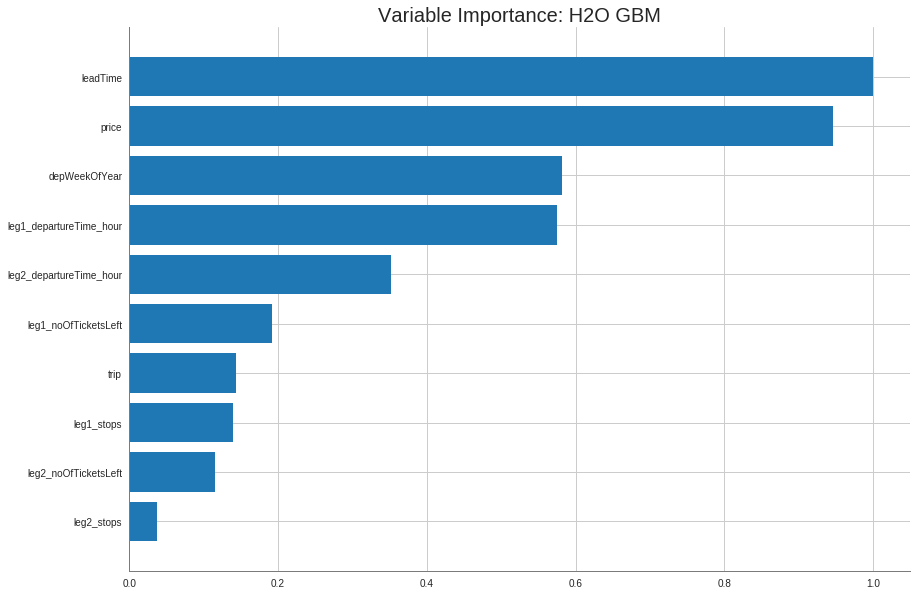

In [120]:
gbm.varimp_plot()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
############### Modelling: priceWillDrop ################
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21207209873558827: 


,0,1,Error,Rate
0,342783.0,94782.0,0.2166,(94782.0/437565.0)
1,35795.0,48692.0,0.4237,(35795.0/84487.0)
Total,378578.0,143474.0,0.2501,(130577.0/522052.0)


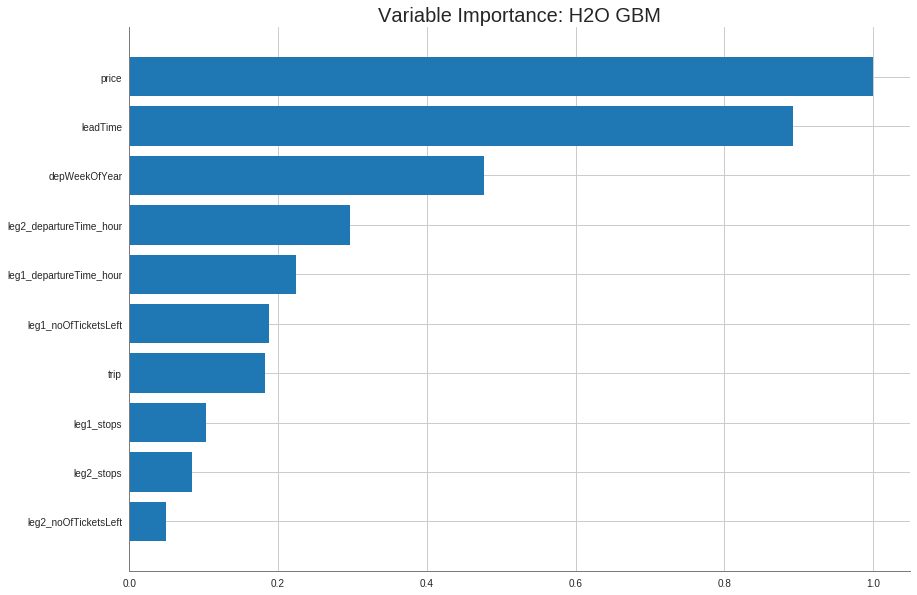

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependencePlot progress: | (cancelled)


H2OJobCancelled: Job<$0301ac11000232d4ffffffff$_9a41b078ff39d64b4ea6060d006490c> was cancelled by the user.

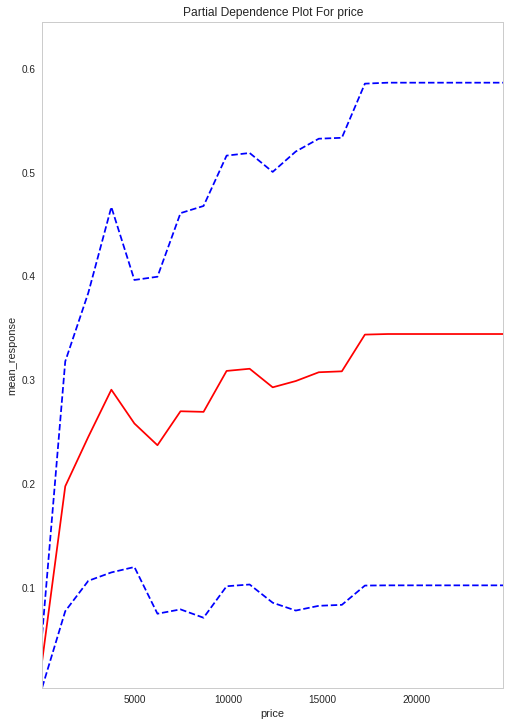

H2O session _sid_9336 closed.


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/shutil.py", line 469, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp99_tz7mh'


In [79]:
# Run AutoML for 30 seconds
# aml = H2OAutoML(max_runtime_secs = 3600)
# aml.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid,
#           leaderboard_frame = test)

# # View the AutoML Leaderboard
# lb = aml.leaderboard
# lb
# # # aml.leader    

# aml.leader

# important_features

# hf[important_features]

%time

imp_threshold = 0.01

print("############### Modelling: " + target + " ################")
# model = aml.leader
model = gbm
print(model.confusion_matrix(valid=True))    
model.varimp_plot()   
important_features = [i[0] for i in model.varimp() if i[3]  > imp_threshold]
for f in important_features:        
    if f in ['price',
#              'leg1_carrierSummary_airlineName',
             'depWeekOfYear',
             'leadTime',
#              'leg2_carrierSummary_airlineName',
             'depDayOfWeek',
             'leg1_departureTime_hour',
             'toCity',
             'leg2_departureTime_hour',
             'searchDayOfWeek',
             'leg1_noOfTicketsLeft',
             'leg2_noOfTicketsLeft',
             'fromCity',
             'leg1_stops',
             'trip']:
#             model.partial_plot(data=valid,cols=[f],server=True, plot=True, nbins=272) 
#         else:
        #model.partial_plot(data=test,cols=[f],server=True, plot=True, nbins=21)     #21    
        model.partial_plot(data=hf2,cols=[f],server=True, plot=True, nbins=21)     #21    

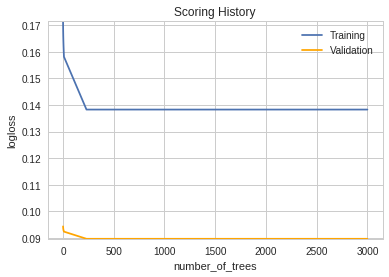

In [121]:
gbm.plot()

# model.download_mojo(path='D:\\flight.pq.11\\', get_genmodel_jar=True)